# Libraries

In [1]:
import os
import sys

current_dir = os.getcwd()
resources_folder = os.path.join(current_dir, '..', 'resources')
sys.path.append(resources_folder)

os.listdir()

['1_validate_initial_files.ipynb',
 '2_retrain_otr_adjudication.ipynb',
 '3_otr_adjudication_pipeline.ipynb',
 '4_otr_existing_exposure_evaluation.ipynb',
 'models.pkl',
 'normalization.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from typing import List, Dict, Optional, Tuple
from statsmodels.discrete.discrete_model import Logit, BinaryResultsWrapper
from sklearn.metrics import roc_auc_score, average_precision_score
import pickle


import snowflake_connector as sc
import model_training as mt
import existing_exposure as ee
import config

# Data reading and processing

**OTR_ADJ_RISK_PREPROCESSED_SAMPLE_MODEL_MONITORING in OTR_ADJ_FLOW**

In [3]:
sf_conn = sc.snowflake_conn(user = "W515059")

c:\Users\W515059\AppData\Local\Programs\Python\Python38\lib\site-packages\snowflake\connector\config_manager.py:344: UserWarning: Bad owner or permissions on C:\Users\W515059\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://myapps.wexinc.com/app/snowflake/exkaea789nRrm6HV7357/sso/saml?SAMLRequest=pZPRcuIgFIZfJcNeJ5CojWWMHVu3W3dbdTTqzN5hgspIIHKI0bdfjHWne9He7B0h34GP80Pv4VRI78gNCK0SFAYEeVxlOhdqm6BF%2Bux3kQeWqZxJrXiCzhzQQ78HrJAlHVR2p2b8UHGwnltIAW1%2BJKgyimoGAqhiBQdqMzofvL3SKCC0NNrqTEv0oeTrCgbAjXWGt5IchNPbWVtSjOu6DupWoM0WR4QQTO6xoy7Itxt%2Fcmf6hA8xaV94Rzh8%2Bu72KNS1BV9pra8Q0Jc0nfrTyTxF3uCm%2BqQVVAU3c26OIuOL2etVAJzB%2BsBI3G2ToAK%2Fdr3zo6A04sgsl0LtA1C63ki255kuysq6LQI3whueY6m3wnVhNExQuRf5r50a%2F3hbLx4nlq2%2Bx5Nqku4jwg7j1TEUq064%2FTnPzsv2aDCEDHnLW8zRJeYRQMVH6hKudVMk6vik5UckDdu0FdJOHEStu9%2FIGzpBoZhtKm8nKM6sLCGo%2BUmorLFz3%2FivOOanPeMs7t6rmSnuXpZxqxNjAI0vYaPr%2FaGNgen%2FV1d6%2BONS7%2Fdy7KIaDadaiuzsPWtTMPt5kmEQNjMi9zcNSnnBhBzkueEALlEpdf1kuPNIkDUVR7h%2F3fXfB9D%2FAw%

In [4]:
query = ''' 
        SELECT *
        FROM "DATAIKU_RAW_SUB"."RISK_FRAUD"."OTR_ADJUDICATION_RISK_OTR_ADJ_RISK_PREPROCESSED_SAMPLE_MODEL_MONITORING";
    '''

cur = sf_conn.cursor()
cur.execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

print(df['decision_date'].min())
print(df['decision_date'].max())
df.head()

2019-01-02
2025-03-17


,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,...,lexis_nexis_reason_code_4_c,adverse_action_code_c,offer_c,detailed_funding_type_2024,pg_required_c,b2bcnt2y_ln,sbfecardcount_ln,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c
0,426106,3770002117863,True,2021-09-15,13.0,RTS Fleet One,OTR,False,Failed,42900.0,...,None,F5;F8,a3L700000004RGEEA2,UNKNOWN,True,0.0,1.0,1.0,3.0,9.0
1,615880,-1,False,2023-06-01,1.0,RTS Fleet One,OTR,False,Passed,1700.0,...,None,E4,a3L700000004RGEEA2,UNKNOWN,True,NaN,NaN,NaN,NaN,5.0
2,665156,-1,False,2023-11-20,4.0,Edge,OTR,False,Passed,14000.0,...,None,F7,a3L0g000000HJ7gEAG,UNKNOWN,True,NaN,0.0,NaN,NaN,11.0
3,533767,-1,False,2022-08-25,1.0,other,OTR,False,Passed,3800.0,...,None,A5,a3L700000004RFwEAM,UNKNOWN,True,-99999.0,-99.0,-99.0,0.0,3.0
4,616055,-1,False,2023-07-11,2.0,RTS Fleet One,OTR,False,None,1.0,...,None,None,a3L700000004RGEEA2,UNKNOWN,False,NaN,NaN,NaN,NaN,4.0


**OTR_ADJUDICATION_RISK_SCOPE_EXTENSION(Existing Exposure Module)**

In [5]:
from numpy import int64

query = ''' 
        SELECT *
        FROM "DATAIKU_RAW_SUB"."RISK_FRAUD"."OTR_ADJUDICATION_RISK_SCOPE_EXTENSION_EE_DATA";
    '''

cur = sf_conn.cursor()
cur.execute(query)
df_ee = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

df_ee['APPLICATION_NUMBER'] = df_ee['APPLICATION_NUMBER'].apply(lambda x: x.split('-')[1] if x is not None else '')
df_ee['APPLICATION_NUMBER'] = pd.to_numeric(df_ee['APPLICATION_NUMBER'], errors='coerce')

df_ee = df_ee.dropna(subset=['APPLICATION_NUMBER'])
df_ee['APPLICATION_NUMBER'] = df_ee['APPLICATION_NUMBER'].astype(int) 


df_ee.head()

,APPLICATION_NUMBER,TOTAL_CL_BANK,N_ACC,UUID,SOURCE,APP_LOB,ACCOUNT_NUMBER,REF_DATE,CREDIT360_ID,FLAG_90_DPD_366_DAYS,...,S_TOTAL_GROSS_SPEND_24M,S_NAF_AVG_GROSS_SPEND_24M,S_OTR_AVG_GROSS_SPEND_24M,S_AVG_GROSS_SPEND_24M,S_NAF_TOTAL_GROSS_SPEND_36M,S_OTR_TOTAL_GROSS_SPEND_36M,S_TOTAL_GROSS_SPEND_36M,S_NAF_AVG_GROSS_SPEND_36M,S_OTR_AVG_GROSS_SPEND_36M,S_AVG_GROSS_SPEND_36M
0,569778,None,2,8d7b41ba-e693-461d-9556-d4ff69e72a40,APPLICATION,OTR,2550002207594,2022-12-23 00:00:00-08:00,1153400.0,0.0,...,33010.58,NaN,2750.881667,2750.881667,NaN,64859.44,64859.44,NaN,2819.975652,2819.975652
1,428573,3000.00,1,d7a391bc-009b-4e4e-a1ad-0beea3d890e7,APPLICATION,OTR,2550002118701,2021-09-23 00:00:00-07:00,2137914.0,0.0,...,29002.56,NaN,3625.320000,3625.320000,NaN,29002.56,29002.56,NaN,3625.320000,3625.320000
2,315415,None,1,None,None,None,None,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,274564,2500.00,1,1a1ab66f-aaa4-489a-9be3-6ff8d056373e,APPLICATION,OTR,3770001904509,2019-03-11 00:00:00-07:00,1611894.0,0.0,...,0.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
4,285813,None,1,None,None,None,None,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# N_ACC
# print(df_ee.N_ACC.value_counts())
# print(f'nulls in N_ACC: {df_ee.N_ACC.isnull().sum()}')

# A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO
print(df_ee.A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO.value_counts())
print(f'nulls in A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO: {df_ee.A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO.isnull().sum()}')

A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO
0.0    13551
1.0     2465
Name: count, dtype: int64
nulls in A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO: 8578


**Risk scope extensions flow**

compute_sample SQL recipe

     case when ee.N_ACC > 0 or (apps.BOOKED = 0 and apps.EXISTING_EXPOSURE_CHECK_C = 'Failed') then 1 else 0 end as EXISTING_EXPOSURE_CHECK_COMBINED

-    ee.N_ACC: Number of accounts
-    apps.BOOKED: Booked as in sf_online_application_c


**Existing Exposure**

compute_ee_aps_feats_filtered recipe

In [7]:
df[df['application_number'].isin([542697, 453557, 604468])][['application_number', 'ar_id', 'booked', 'decision_date', 'existing_exposure_check_c', 'credit_line_requested_c', 'risk_grade_c', 'fico_score', 'ln_score', 'ln_segment', 'blended_risk_score_c', 'is_bad']]

,application_number,ar_id,booked,decision_date,existing_exposure_check_c,credit_line_requested_c,risk_grade_c,fico_score,ln_score,ln_segment,blended_risk_score_c,is_bad
3472,453557,1043502201668,True,2022-01-19,Passed,0.0,NaN,NaN,674.0,sba,NaN,False
160894,604468,3770017716132,True,2023-05-13,None,1.0,NaN,NaN,712.0,sba,NaN,False
307325,542697,5577702201117,True,2022-09-27,Failed,4700.0,2.0,NaN,834.0,sbfe,NaN,False


## Merge data

In [8]:
merged_df = pd.merge(df, df_ee, left_on='application_number', right_on='APPLICATION_NUMBER', how='left')

pd.set_option('display.max_columns', None)
merged_df[merged_df['N_ACC'].notnull()].head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,years_in_business_c,risk_grade_c,security_deposit_c,account_type_c,credit_line_approved_c,offer_name_wf_txt_c,past_due_total,current_ar_total,pmts_amount,days_to_90dpd,chargeoff,chargeoff_y1,funding_type,fico_score,ln_score,ln_segment,is_bad,credit_decision_c,bpav_check_c,blended_risk_score_c,instant_approval_c,risk_grade_blended_c,risk_grade_confidence_assignment_c,risk_platform_id_c,lexis_nexis_biid_score_c,lexis_nexis_custom_model_score_c,lexis_nexis_cvi_score_c,lexis_nexis_fraud_point_result_c,lexis_nexis_sbfe_c,lexis_nexis_sbfe_model_score_c,lexis_nexis_sbfe_score_c,lexis_nexis_sbfe_trade_count_c,lexis_nexis_sbfe_trades_c,final_decision_run_count_c,application_title_c,guardrail_violated_c,auto_decision_comments_c,decision_comments_c,automatically_generated_number_c,disable_instant_decisioning_c,credit_analyst_c,campaign_type_rdm_c,first_90dpd_date,dnb_reason_code_c,lexis_nexis_reason_code_1_c,lexis_nexis_reason_code_2_c,lexis_nexis_reason_code_3_c,lexis_nexis_reason_code_4_c,adverse_action_code_c,offer_c,detailed_funding_type_2024,pg_required_c,b2bcnt2y_ln,sbfecardcount_ln,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c,APPLICATION_NUMBER,TOTAL_CL_BANK,N_ACC,UUID,SOURCE,APP_LOB,ACCOUNT_NUMBER,REF_DATE,CREDIT360_ID,FLAG_90_DPD_366_DAYS,D_DAYS_SINCE_LAST_1_DPD,D_DAYS_SINCE_LAST_1_DPD_LT_90,D_DAYS_SINCE_LAST_10_DPD,D_DAYS_SINCE_LAST_30_DPD,D_DAYS_SINCE_LAST_60_DPD,D_DAYS_SINCE_LAST_90_DPD,D_MAX_DAYS_PAST_DUE_6M,D_MAX_DAYS_PAST_DUE_12M,D_MAX_DAYS_PAST_DUE_24M,D_MAX_DAYS_PAST_DUE_36M,D_MAX_DAYS_PAST_DUE_84M,D_SUM_TIMES_1_DAYS_PAST_DUE_6M,D_SUM_TIMES_30_DAYS_PAST_DUE_6M,D_SUM_TIMES_60_DAYS_PAST_DUE_6M,D_SUM_TIMES_90_DAYS_PAST_DUE_6M,D_FRAC_ACC_1_PAST_DUE_6M,D_FRAC_ACC_30_PAST_DUE_6M,D_FRAC_ACC_60_PAST_DUE_6M,D_FRAC_ACC_90_PAST_DUE_6M,D_SUM_TIMES_1_DAYS_PAST_DUE_12M,D_SUM_TIMES_30_DAYS_PAST_DUE_12M,D_SUM_TIMES_60_DAYS_PAST_DUE_12M,D_SUM_TIMES_90_DAYS_PAST_DUE_12M,D_FRAC_ACC_1_PAST_DUE_12M,D_FRAC_ACC_30_PAST_DUE_12M,D_FRAC_ACC_60_PAST_DUE_12M,D_FRAC_ACC_90_PAST_DUE_12M,D_SUM_TIMES_1_DAYS_PAST_DUE_24M,D_SUM_TIMES_30_DAYS_PAST_DUE_24M,D_SUM_TIMES_60_DAYS_PAST_DUE_24M,D_SUM_TIMES_90_DAYS_PAST_DUE_24M,D_FRAC_ACC_1_PAST_DUE_24M,D_FRAC_ACC_30_PAST_DUE_24M,D_FRAC_ACC_60_PAST_DUE_24M,D_FRAC_ACC_90_PAST_DUE_24M,D_SUM_TIMES_1_DAYS_PAST_DUE_36M,D_SUM_TIMES_30_DAYS_PAST_DUE_36M,D_SUM_TIMES_60_DAYS_PAST_DUE_36M,D_SUM_TIMES_90_DAYS_PAST_DUE_36M,D_FRAC_ACC_1_PAST_DUE_36M,D_FRAC_ACC_30_PAST_DUE_36M,D_FRAC_ACC_60_PAST_DUE_36M,D_FRAC_ACC_90_PAST_DUE_36M,D_TREND_TIMES_1_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_30_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_60_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_90_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_1_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_30_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_60_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_90_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_1_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_30_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_60_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_90_DAYS_PAST_DUE_24M_36M,SIC_CODE,LATEST_CONN_ACC_NUMBER,A_DAYS_SINCE_FIRST_ACCOUNT_OPENING,A_DAYS_SINCE_FIRST_ACCOUNT_STILL_ACTIVE_OPENING,A_DAYS_SINCE_LAST_ACCOUNT_OPENING,A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO,A_N_ACCOUNT_OPENINGS_6M,A_N_ACCOUNT_OPENINGS_12M,A_N_ACCOUNT_OPENINGS_24M,A_N_ACCOUNT_OPENINGS_36M,A_N_CONNECTED_ACCS,A_N_CONNECTED_NAF_ACCS,A_N_CONNECTED_OTR_ACCS,A_N_CONNECTED_CPS_ACCS,A_N_CONNECTED_OTR_CUSTOMERS,A_N_CURRENTLY_TERMINATED_ACCS,A_N_CONNECTED_PLATFORMS,A_N_CONNECTED_TCHEKMC_ACCS,A_N_CONNECTED_TCHEK_ACCS,SEG_NUM_EX_ACCOUNTS,SEG_NUM_EX_NAF_ACCOUNTS,SEG_NUM_EX_OTR_ACCOUNTS,SEG_NUM_EX_CPS_ACCOUNTS,SEG_ALL_EX_ACCOUNTS_ARE_NAF,SEG_ALL_EX_ACCOUNTS_ARE_OTR,SEG_ALL_EX_ACCOUNTS_ARE_CPS,SEG_ALL_EX_ACCOUNTS_ARE_NAF_OR_OTR,SEG_ALL_EX_ACCOUNTS_ARE_NAF_OR_CPS,SEG_ALL_EX_ACCOUNTS_ARE_OTR_OR_CPS,SEG_ALL_LOB_PRESENT_IN_EX_ACCOUNTS,SEG_HAS_EX_SPECIAL_SUSPENSION_ACCOUNT,SEG_ALL_EX_ACCOUNTS_ARE_SPECIAL_SU

In [9]:
print(merged_df.N_ACC.value_counts())
print(f'nulls in N_ACC: {merged_df.N_ACC.isnull().sum()}')

# merged_df['A_DAYS_SINCE_LAST_ACCOUNT_OPENING'].head()

N_ACC
1.0       18447
2.0        4327
3.0        1158
4.0         338
5.0         110
6.0          36
7.0          16
8.0           8
80.0          2
81.0          2
10.0          2
21.0          2
82.0          2
85.0          1
6240.0        1
84.0          1
79.0          1
6238.0        1
48.0          1
6484.0        1
6216.0        1
44.0          1
12.0          1
6198.0        1
9.0           1
6633.0        1
6255.0        1
13.0          1
16.0          1
49.0          1
18.0          1
990.0         1
6223.0        1
6265.0        1
6624.0        1
6242.0        1
27.0          1
86.0          1
29.0          1
11.0          1
Name: count, dtype: int64
nulls in N_ACC: 311484


In [10]:
merged_df.columns.tolist()

['application_number',
 'ar_id',
 'booked',
 'decision_date',
 'number_of_trucks_c',
 'program_group',
 'product_type_c',
 'fraud_flag_c',
 'existing_exposure_check_c',
 'credit_line_requested_c',
 'years_in_business_c',
 'risk_grade_c',
 'security_deposit_c',
 'account_type_c',
 'credit_line_approved_c',
 'offer_name_wf_txt_c',
 'past_due_total',
 'current_ar_total',
 'pmts_amount',
 'days_to_90dpd',
 'chargeoff',
 'chargeoff_y1',
 'funding_type',
 'fico_score',
 'ln_score',
 'ln_segment',
 'is_bad',
 'credit_decision_c',
 'bpav_check_c',
 'blended_risk_score_c',
 'instant_approval_c',
 'risk_grade_blended_c',
 'risk_grade_confidence_assignment_c',
 'risk_platform_id_c',
 'lexis_nexis_biid_score_c',
 'lexis_nexis_custom_model_score_c',
 'lexis_nexis_cvi_score_c',
 'lexis_nexis_fraud_point_result_c',
 'lexis_nexis_sbfe_c',
 'lexis_nexis_sbfe_model_score_c',
 'lexis_nexis_sbfe_score_c',
 'lexis_nexis_sbfe_trade_count_c',
 'lexis_nexis_sbfe_trades_c',
 'final_decision_run_count_c',
 'app

### Define Existing Exposure

In [11]:
# define existing_exposure as 1 if existing_exposure_check_c =='Failed' or N_ACC > 0
merged_df['existing_exposure'] = np.where((merged_df['existing_exposure_check_c'] == 'Failed') | (merged_df['N_ACC'] > 0), 1, 0)

print(merged_df['existing_exposure'].value_counts())

# group by existing_exposure, existing_exposure_check_c, N_ACC > 0 and count
merged_df['n_acc_group'] = np.where(merged_df['N_ACC'] > 0, 1, 0)
merged_df.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()


existing_exposure
0    250432
1     85529
Name: count, dtype: int64


existing_exposure  existing_exposure_check_c  n_acc_group
0                  Passed                     0              242427
1                  Failed                     0               61052
                                              1               13654
                   Passed                     1                9607
Name: application_number, dtype: int64

In [12]:
print(merged_df['decision_date'].min())
print(merged_df['decision_date'].max())

print(merged_df[merged_df['N_ACC'].notnull()]['decision_date'].min())
print(merged_df[merged_df['N_ACC'].notnull()]['decision_date'].max())


2019-01-02
2025-03-17
2019-01-02
2024-03-13


### Data Processing

In [13]:
# Select data for model development and for testing purposes
data_dev, filters_applied_dev = ee.slice_to_dev_sample_ee(data=merged_df.loc[pd.to_datetime(merged_df["decision_date"]).dt.year == config.MODEL_DEVELOPMENT_YEAR])
data_test, filters_applied_test = ee.slice_to_dev_sample_ee(data=merged_df.loc[
        (pd.to_datetime(merged_df["decision_date"]).dt.year == config.MODEL_APPLICATION_YEAR) & (
                    pd.to_datetime(merged_df["decision_date"]).dt.quarter == config.MODEL_APPLICATION_QUARTER)
        ])
data_scoring, filters_applied_scoring = ee.slice_to_dev_sample_ee(data=merged_df.loc[
        (pd.to_datetime(merged_df["decision_date"]) > config.MODEL_DEPLOYMENT_DATE)
        ]   )


In [14]:
data_dev['n_acc_group'] = np.where(data_dev['N_ACC'] > 0, 1, 0)
data_dev.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              6853
                                              1              1801
                   Passed                     1              1473
Name: application_number, dtype: int64

In [15]:
data_test['n_acc_group'] = np.where(data_test['N_ACC'] > 0, 1, 0)
data_test.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              3702
                                              1               943
                   Passed                     1               635
Name: application_number, dtype: int64

As existing exposure data ends on March 13, 2024, re-execution of the Dataiku flow is required to get all accounts with existing exposure in the current data.

In [16]:
data_scoring['n_acc_group'] = np.where(data_scoring['N_ACC'] > 0, 1, 0)
data_scoring.groupby(['existing_exposure', 'existing_exposure_check_c', 'n_acc_group'])['application_number'].count()

existing_exposure  existing_exposure_check_c  n_acc_group
1                  Failed                     0              8384
                                              1                 1
Name: application_number, dtype: int64

Original data shape: (335961, 339)
Filters applied for model development sample: {'original_rows': 53416, 'unique_apps': 53416, 'remove_new_applications': 10675, 'remove_60dpd_in_last_7_years': 10671, 'remove_currently_suspended': 10660, 'remove_currently_delinquent': 10655, 'remove_chargeoffs_in_last_7_years': 10649, 'remove_last_account_opened_lt_90_days': 10139}
Filters applied for model application sample: {'original_rows': 19494, 'unique_apps': 19494, 'remove_new_applications': 5546, 'remove_60dpd_in_last_7_years': 5545, 'remove_currently_suspended': 5537, 'remove_currently_delinquent': 5535, 'remove_chargeoffs_in_last_7_years': 5525, 'remove_last_account_opened_lt_90_days': 5301}
Filters applied for model scoring sample: {'original_rows': 47745, 'unique_apps': 47316, 'remove_new_applications': 8419, 'remove_60dpd_in_last_7_years': 8419, 'remove_currently_suspended': 8419, 'remove_currently_delinquent': 8419, 'remove_chargeoffs_in_last_7_years': 8419, 'remove_last_account_opened_l

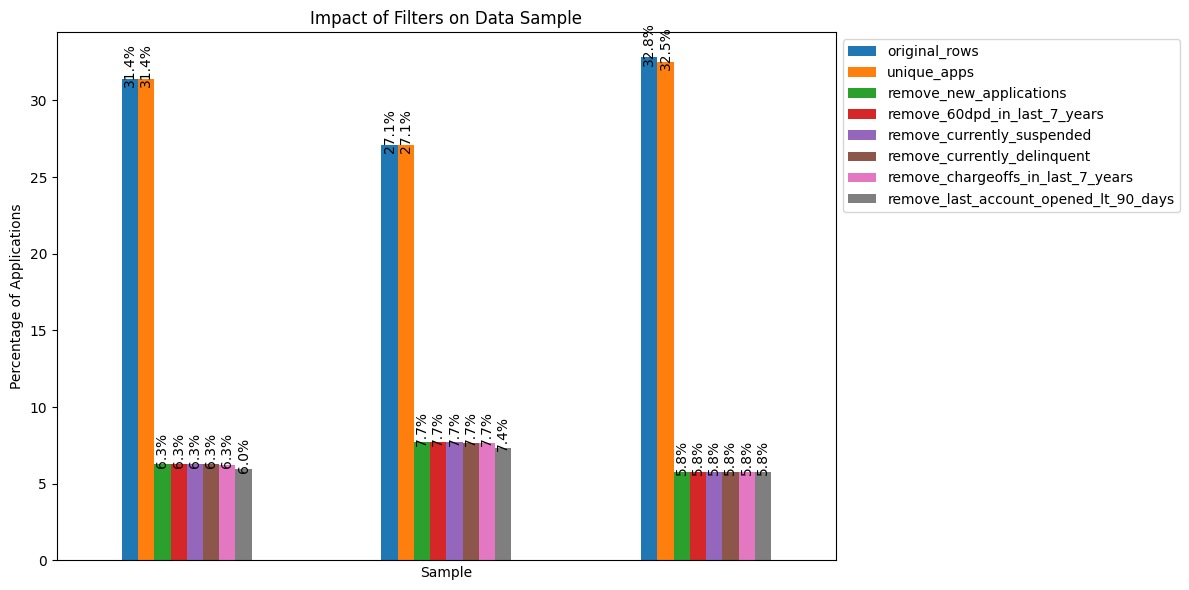

In [17]:
print(f"Original data shape: {merged_df.shape}")
print(f"Filters applied for model development sample: {filters_applied_dev}")
print(f"Filters applied for model application sample: {filters_applied_test}")
print(f"Filters applied for model scoring sample: {filters_applied_scoring}")

mt.filters_applied_chart(filters_applied_dev, filters_applied_test, filters_applied_scoring)

Model development Through the door number of transactions: 10139


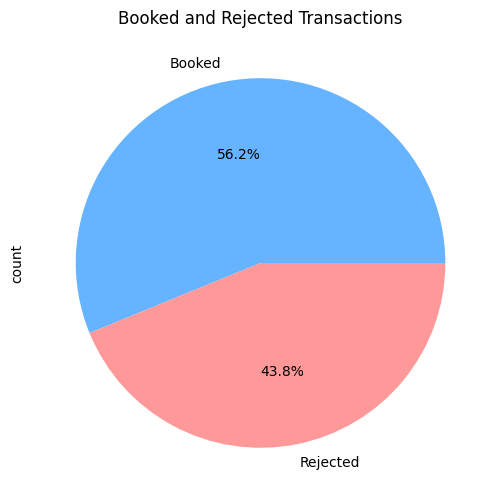

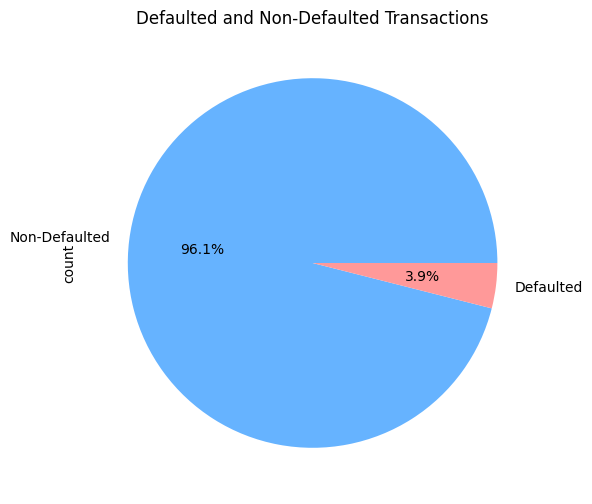

In [18]:
print(f"Model development Through the door number of transactions: {data_dev.shape[0]}")
mt.booked_rejected_pie_chart(data_dev)
mt.default_pie_chart(data_dev)

Model application  Through the door number of transactions: 5301


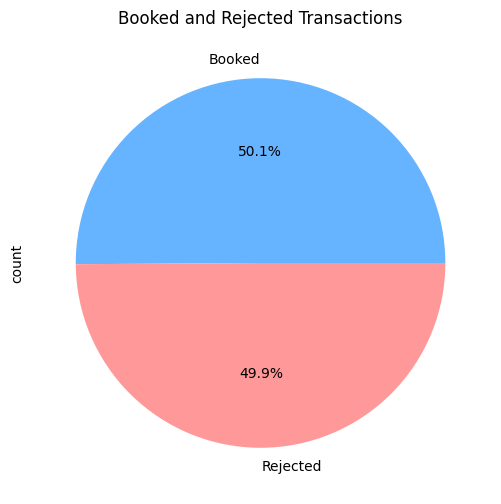

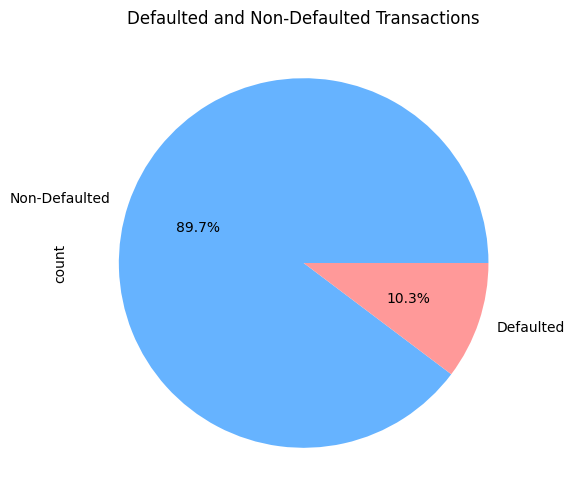

In [19]:
print(f"Model application  Through the door number of transactions: {data_test.shape[0]}")
mt.booked_rejected_pie_chart(data_test)
mt.default_pie_chart(data_test)

Model scoring Through the door number of transactions: 8419


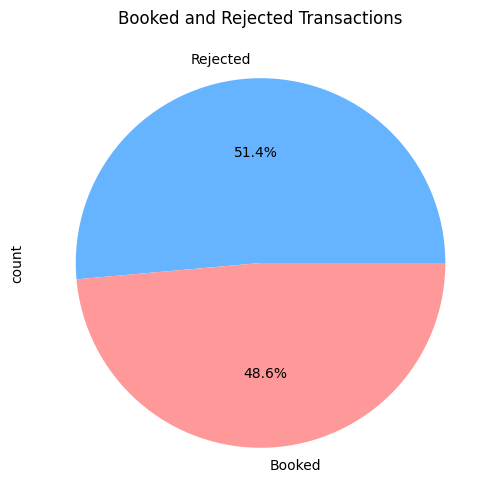

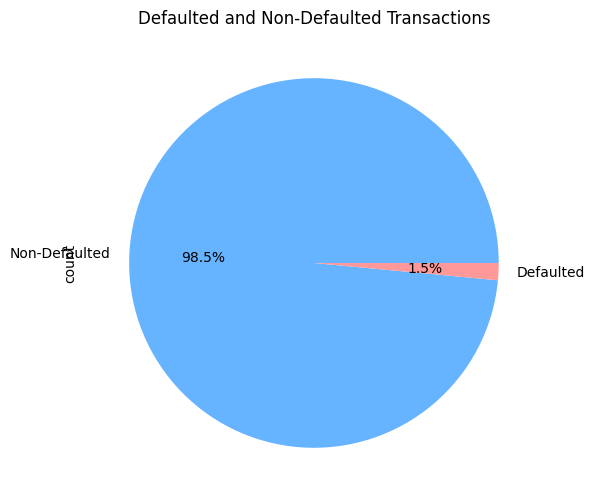

In [20]:
print(f"Model scoring Through the door number of transactions: {data_scoring.shape[0]}")
mt.booked_rejected_pie_chart(data_scoring)
mt.default_pie_chart(data_scoring)

# New Model

In [21]:
conditions = config.CONDITIONS_NEW_MODEL
choices = config.CHOICES_NEW_MODEL
risk_grade_segments = config.RISK_GRADE_SEGMENTS_NEW_MODEL
NORMALIZE_SCORES = config.NORMALIZE_SCORES_NEW_MODEL
new_pd_risk_grade_thresholds = config.NEW_PD_RISK_GRADE_THRESHOLDS
approval_thresholds = config.APPROVAL_THRESHOLDS

# Apply the function to both dataframes
data_dev = mt.apply_risk_grade_path(data_dev, conditions, choices)
data_test = mt.apply_risk_grade_path(data_test, conditions, choices)
data_scoring = mt.apply_risk_grade_path(data_scoring, conditions, choices)
print(len(data_test))
print(len(data_scoring))

5301
8419


In [22]:
# Load the models and normalization parameters
with open('models.pkl', 'rb') as f:
    models_dict = pickle.load(f)

with open('normalization.pkl', 'rb') as f:
    normalization_dict = pickle.load(f)

In [23]:
data_dev_filtered = mt.risk_grade_estimate_preprocessing(data_dev)
data_test_filtered = mt.risk_grade_estimate_preprocessing(data_test)
data_scoring_filtered = mt.risk_grade_estimate_preprocessing(data_scoring)

print(len(data_dev_filtered))

print(data_dev_filtered.risk_grade_path.value_counts())

print(len(data_test_filtered))

print(data_test_filtered.risk_grade_path.value_counts())

print(len(data_scoring_filtered))

print(data_scoring_filtered.risk_grade_path.value_counts())

data_dev_scored = mt.apply_fitted_models_to_data(
    data=data_dev_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_test_scored = mt.apply_fitted_models_to_data(
    data=data_test_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

data_scoring_scored = mt.apply_fitted_models_to_data(
    data=data_scoring_filtered,
    models_dict=models_dict,
    normalization_dict=normalization_dict,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    NORMALIZE_SCORES = NORMALIZE_SCORES,
)

10139
risk_grade_path
no_pg_and_1_plus_sbfe_tradeline                                               3817
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit    2276
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit                    1250
no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline                    889
pg_and_1_plus_sbfe_tradeline_and_fico_hit                                      590
no_pg_no_sbfe_no_sba_no_fico                                                   564
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit                  248
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit                 198
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit        140
pg_and_1_plus_sbfe_tradeline_and_fico_no_hit                                   126
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit               41
Name: count, dtype: int64
5301
risk_grade_path
no_pg_and_1_plus_s

In [24]:
normalization_dict

{'pg_sbfe_ln_and_fico': {'ln_score': {'std': 54.73682089179337,
   'mean': 691.5942440210782},
  'fico_score_filled': {'std': 63.85355451455604, 'mean': 710.1576813944062}},
 'pg_sbfe_ln_only': {'ln_score': {'std': 66.7108709032535,
   'mean': 683.9196787148594}},
 'pg_sba_ln_and_fico': {'ln_score': {'std': 45.731810666248805,
   'mean': 685.5669515669516},
  'fico_score_filled': {'std': 72.54145953802362, 'mean': 647.5356125356126}},
 'pg_sba_ln_only': {'ln_score': {'std': 49.149407601987264,
   'mean': 674.6178861788618}},
 'pg_fico_only': {'fico_score': {'std': 74.20708340100364,
   'mean': 678.3740901133327}},
 'pg_no_hits': {},
 'no_pg_sbfe_ln_only': {'ln_score': {'std': 62.03816399637875,
   'mean': 695.6245081506464}},
 'no_pg_sba_ln_only': {'ln_score': {'std': 50.57822613372447,
   'mean': 682.0095124851367}},
 'no_pg_no_hits': {},
 'no_pg_false_sba_fico_hit': {},
 'no_pg_false_sba_no_hits': {}}

### Booking and predicted booking tables

In [25]:
data_dev_scored['pg_subsegment'] = np.where((data_dev_scored['number_of_trucks_c'] <= 7) | (data_dev_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')
data_test_scored['pg_subsegment'] = np.where((data_test_scored['number_of_trucks_c'] <= 7) | (data_test_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')
data_scoring_scored['pg_subsegment'] = np.where((data_scoring_scored['number_of_trucks_c'] <= 7) | (data_scoring_scored['years_in_business_num_c'] <= 3), 'pg_should_be_required', 'pg_should_not_be_required')

In [26]:
PG_SUBSEGMENTS = {
    "pg_should_be_required": {"condition": {"column": "pg_subsegment", "allowed_values": ["pg_should_be_required"]}},
    "pg_should_not_be_required": {"condition": {"column": "pg_subsegment", "allowed_values": ["pg_should_not_be_required"]}}
}

In [27]:

# Training: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_dev_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# Display the results
# print(segment_stats_df)


# Test: Calculate segment statistics with approval/decline thresholds
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_test_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# # Display the results
# print(segment_stats_df)

# Current: 
segment_stats_df = mt.calculate_segment_statistics_with_approval(
    data=data_scoring_scored,
    RISK_GRADE_SEGMENTS=risk_grade_segments,
    risk_grade_thresholds=new_pd_risk_grade_thresholds,
    approval_thresholds=approval_thresholds,
    PG_SUBSEGMENTS=PG_SUBSEGMENTS,
)

# # Display the results
# print(segment_stats_df)

segment_stats_df

,segment_name,total_rows,num_booked,num_non_booked,booked_is_bad,predicted_booked,predicted_booked_is_bad,predicted_declined,min_number_of_trucks,max_number_of_trucks,avg_number_of_trucks,min_years_in_business,max_years_in_business,avg_years_in_business,subsegment_name
0,pg_sbfe_ln_and_fico,2356,1231,1125,20,1478,14,878,0.0,44.0,2.485569,0.0,108.0,7.562394,pg_should_be_required
1,pg_sbfe_ln_and_fico,27,15,12,0,21,0,6,8.0,50.0,16.777778,4.0,4.0,4.000000,pg_should_not_be_required
2,pg_sbfe_ln_only,714,339,375,5,545,3,169,0.0,50.0,2.679272,0.0,78.0,8.701681,pg_should_be_required
3,pg_sbfe_ln_only,11,4,7,0,9,0,2,8.0,95.0,23.363636,4.0,27.0,10.454545,pg_should_not_be_required
4,pg_sba_ln_and_fico,332,105,227,1,81,0,251,1.0,8.0,2.442771,0.0,32.0,5.298193,pg_should_be_required
5,pg_sba_ln_and_fico,6,1,5,0,1,0,5,8.0,20.0,10.333333,4.0,4.0,4.000000,pg_should_not_be_required
6,pg_sba_ln_only,115,37,78,2,0,0,115,1.0,25.0,2.365217,1.0,21.0,5.417391,pg_should_be_required
7,pg_sba_ln_only,1,1,0,0,0,0,1,8.0,8.0,8.000000,4.0,4.0,4.000000,pg_should_not_be_required
8,pg_fico_only,2127,936,1191,12,1021,11,1106,0.0,150.0,2.247767,0.0,325.0,5.061119,pg_should_be_required
9,pg_fico_only,30,11,19,1,16,1,14,8.0,115.0,21.333333,4.0,69.0,11.066667,pg_should_not_be_required


In [28]:
data_scoring_filtered[data_scoring_filtered['risk_grade_path'] == 'nan'].head()

,application_number,ar_id,booked,decision_date,number_of_trucks_c,program_group,product_type_c,fraud_flag_c,existing_exposure_check_c,credit_line_requested_c,years_in_business_c,risk_grade_c,security_deposit_c,account_type_c,credit_line_approved_c,offer_name_wf_txt_c,past_due_total,current_ar_total,pmts_amount,days_to_90dpd,chargeoff,chargeoff_y1,funding_type,fico_score,ln_score,ln_segment,is_bad,credit_decision_c,bpav_check_c,blended_risk_score_c,instant_approval_c,risk_grade_blended_c,risk_grade_confidence_assignment_c,risk_platform_id_c,lexis_nexis_biid_score_c,lexis_nexis_custom_model_score_c,lexis_nexis_cvi_score_c,lexis_nexis_fraud_point_result_c,lexis_nexis_sbfe_c,lexis_nexis_sbfe_model_score_c,lexis_nexis_sbfe_score_c,lexis_nexis_sbfe_trade_count_c,lexis_nexis_sbfe_trades_c,final_decision_run_count_c,application_title_c,guardrail_violated_c,auto_decision_comments_c,decision_comments_c,automatically_generated_number_c,disable_instant_decisioning_c,credit_analyst_c,campaign_type_rdm_c,first_90dpd_date,dnb_reason_code_c,lexis_nexis_reason_code_1_c,lexis_nexis_reason_code_2_c,lexis_nexis_reason_code_3_c,lexis_nexis_reason_code_4_c,adverse_action_code_c,offer_c,detailed_funding_type_2024,pg_required_c,b2bcnt2y_ln,sbfecardcount_ln,sbfeaccountcount_ln,sbfehitindex_ln,years_in_business_num_c,APPLICATION_NUMBER,TOTAL_CL_BANK,N_ACC,UUID,SOURCE,APP_LOB,ACCOUNT_NUMBER,REF_DATE,CREDIT360_ID,FLAG_90_DPD_366_DAYS,D_DAYS_SINCE_LAST_1_DPD,D_DAYS_SINCE_LAST_1_DPD_LT_90,D_DAYS_SINCE_LAST_10_DPD,D_DAYS_SINCE_LAST_30_DPD,D_DAYS_SINCE_LAST_60_DPD,D_DAYS_SINCE_LAST_90_DPD,D_MAX_DAYS_PAST_DUE_6M,D_MAX_DAYS_PAST_DUE_12M,D_MAX_DAYS_PAST_DUE_24M,D_MAX_DAYS_PAST_DUE_36M,D_MAX_DAYS_PAST_DUE_84M,D_SUM_TIMES_1_DAYS_PAST_DUE_6M,D_SUM_TIMES_30_DAYS_PAST_DUE_6M,D_SUM_TIMES_60_DAYS_PAST_DUE_6M,D_SUM_TIMES_90_DAYS_PAST_DUE_6M,D_FRAC_ACC_1_PAST_DUE_6M,D_FRAC_ACC_30_PAST_DUE_6M,D_FRAC_ACC_60_PAST_DUE_6M,D_FRAC_ACC_90_PAST_DUE_6M,D_SUM_TIMES_1_DAYS_PAST_DUE_12M,D_SUM_TIMES_30_DAYS_PAST_DUE_12M,D_SUM_TIMES_60_DAYS_PAST_DUE_12M,D_SUM_TIMES_90_DAYS_PAST_DUE_12M,D_FRAC_ACC_1_PAST_DUE_12M,D_FRAC_ACC_30_PAST_DUE_12M,D_FRAC_ACC_60_PAST_DUE_12M,D_FRAC_ACC_90_PAST_DUE_12M,D_SUM_TIMES_1_DAYS_PAST_DUE_24M,D_SUM_TIMES_30_DAYS_PAST_DUE_24M,D_SUM_TIMES_60_DAYS_PAST_DUE_24M,D_SUM_TIMES_90_DAYS_PAST_DUE_24M,D_FRAC_ACC_1_PAST_DUE_24M,D_FRAC_ACC_30_PAST_DUE_24M,D_FRAC_ACC_60_PAST_DUE_24M,D_FRAC_ACC_90_PAST_DUE_24M,D_SUM_TIMES_1_DAYS_PAST_DUE_36M,D_SUM_TIMES_30_DAYS_PAST_DUE_36M,D_SUM_TIMES_60_DAYS_PAST_DUE_36M,D_SUM_TIMES_90_DAYS_PAST_DUE_36M,D_FRAC_ACC_1_PAST_DUE_36M,D_FRAC_ACC_30_PAST_DUE_36M,D_FRAC_ACC_60_PAST_DUE_36M,D_FRAC_ACC_90_PAST_DUE_36M,D_TREND_TIMES_1_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_30_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_60_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_90_DAYS_PAST_DUE_6M_12M,D_TREND_TIMES_1_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_30_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_60_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_90_DAYS_PAST_DUE_12M_24M,D_TREND_TIMES_1_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_30_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_60_DAYS_PAST_DUE_24M_36M,D_TREND_TIMES_90_DAYS_PAST_DUE_24M_36M,SIC_CODE,LATEST_CONN_ACC_NUMBER,A_DAYS_SINCE_FIRST_ACCOUNT_OPENING,A_DAYS_SINCE_FIRST_ACCOUNT_STILL_ACTIVE_OPENING,A_DAYS_SINCE_LAST_ACCOUNT_OPENING,A_FLAG_LAST_ACCOUNT_OPENED_3M_AGO,A_N_ACCOUNT_OPENINGS_6M,A_N_ACCOUNT_OPENINGS_12M,A_N_ACCOUNT_OPENINGS_24M,A_N_ACCOUNT_OPENINGS_36M,A_N_CONNECTED_ACCS,A_N_CONNECTED_NAF_ACCS,A_N_CONNECTED_OTR_ACCS,A_N_CONNECTED_CPS_ACCS,A_N_CONNECTED_OTR_CUSTOMERS,A_N_CURRENTLY_TERMINATED_ACCS,A_N_CONNECTED_PLATFORMS,A_N_CONNECTED_TCHEKMC_ACCS,A_N_CONNECTED_TCHEK_ACCS,SEG_NUM_EX_ACCOUNTS,SEG_NUM_EX_NAF_ACCOUNTS,SEG_NUM_EX_OTR_ACCOUNTS,SEG_NUM_EX_CPS_ACCOUNTS,SEG_ALL_EX_ACCOUNTS_ARE_NAF,SEG_ALL_EX_ACCOUNTS_ARE_OTR,SEG_ALL_EX_ACCOUNTS_ARE_CPS,SEG_ALL_EX_ACCOUNTS_ARE_NAF_OR_OTR,SEG_ALL_EX_ACCOUNTS_ARE_NAF_OR_CPS,SEG_ALL_EX_ACCOUNTS_ARE_OTR_OR_CPS,SEG_ALL_LOB_PRESENT_IN_EX_ACCOUNTS,SEG_HAS_EX_SPECIAL_SUSPENSION_ACCOUNT,SEG_ALL_EX_ACCOUNTS_ARE_SPECIAL_SU

#### AUC - PR AUC

In [29]:

df_performance = data_test_scored.copy()
df_performance['segment'] = df_performance['risk_grade_path'].replace({'double_no_hit': 'no_hit_unknown', 'UNKNOWN': 'no_hit_unknown'})

# Calculate segment counts
segment_counts = df_performance['segment'].value_counts()

# Initialize dictionaries to store AUC and PR-AUC results
auc_results = {}
prauc_results = {}

for segment in df_performance['segment'].unique():
    segment_data = df_performance[df_performance['segment'] == segment]

    if segment == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)  # Convert boolean to integer
        y_score = segment_data['pd_pg_sbfe_ln_and_fico']
        
    elif segment == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sbfe_ln_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sba_ln_and_fico']

    elif segment == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_sba_ln_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_fico_only']

    elif segment == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit':
        segment_data = segment_data.dropna(subset=['pd_pg_no_hits'])
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_pg_no_hits']

    elif segment == 'no_pg_and_1_plus_sbfe_tradeline':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_sbfe_ln_only']

    elif segment == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_sba_ln_only']

    elif segment == 'no_pg_no_sbfe_no_sba_no_fico':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_no_hits']

    elif segment == 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_false_sba_fico_hit']

    elif segment == 'no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit':
        y_true = (segment_data['is_bad']).astype(int)
        y_score = segment_data['pd_no_pg_false_sba_no_hits']

    else:
        continue

    auc = roc_auc_score(y_true, y_score)
    auc_results[segment] = auc

    prauc = average_precision_score(y_true, y_score)
    prauc_results[segment] = prauc


# Print the results
print("Segment Counts:\n", segment_counts)
print("\nAUC Results:\n", auc_results)
print("\nPR-AUC Results:\n", prauc_results)

Segment Counts:
 segment
no_pg_and_1_plus_sbfe_tradeline                                               2283
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit                     748
pg_and_1_plus_sbfe_tradeline_and_fico_hit                                      604
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_no_hit     565
no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline                    261
no_pg_no_sbfe_no_sba_no_fico                                                   205
pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_no_hit                  188
pg_and_1_plus_sbfe_tradeline_and_fico_no_hit                                   169
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit                 136
no_pg_and_no_sbfe_tradeline_and_false_1_plus_sba_tradeline_and_fico_hit         84
pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit               58
Name: count, dtype: int64

AUC Results:
 {'pg_and_1_plus_sbfe_

## Lift Charts

#### pd_pg_sbfe_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

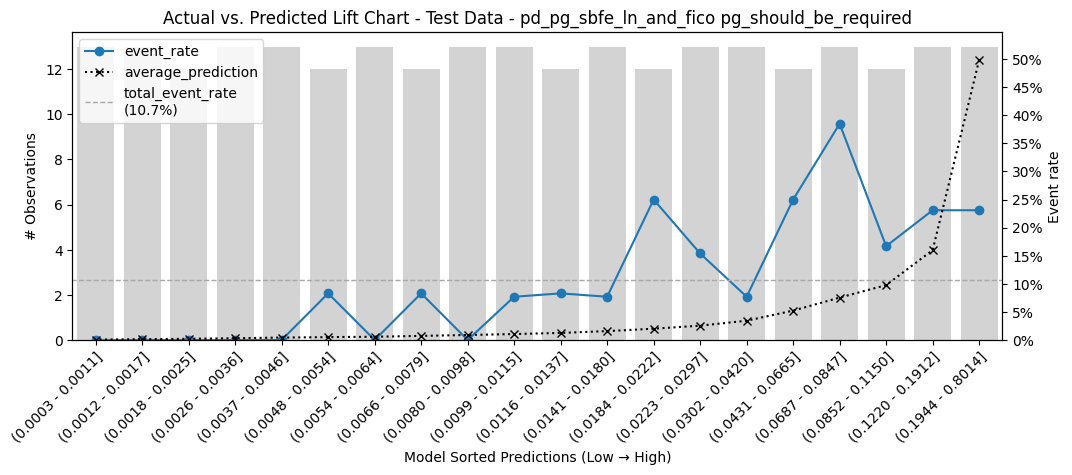

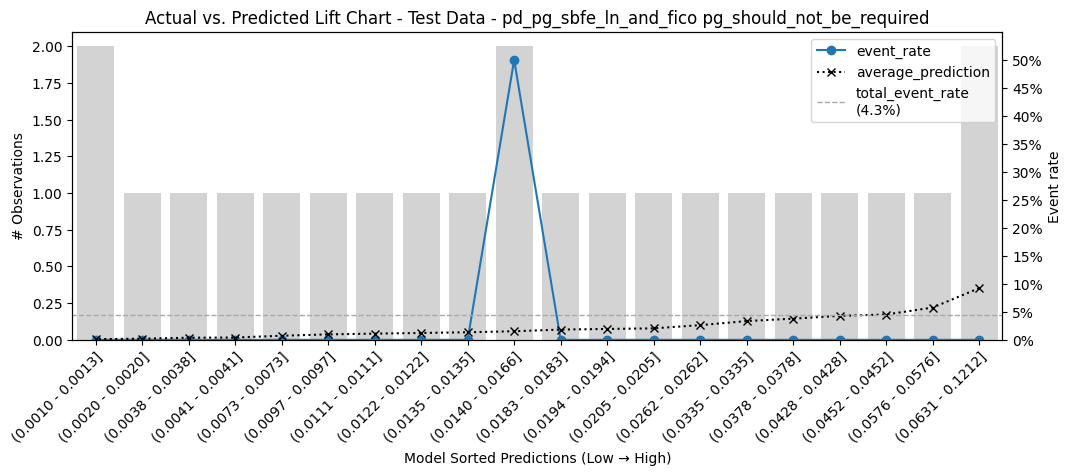

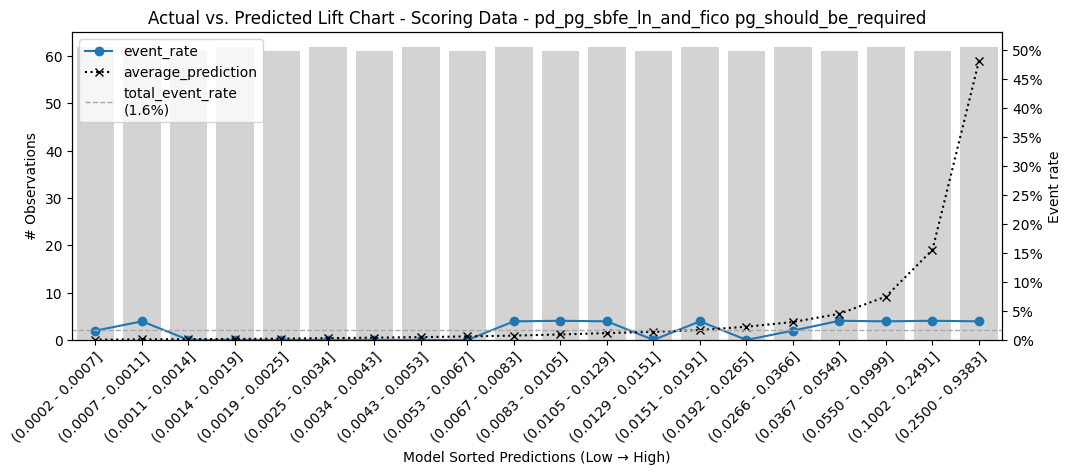

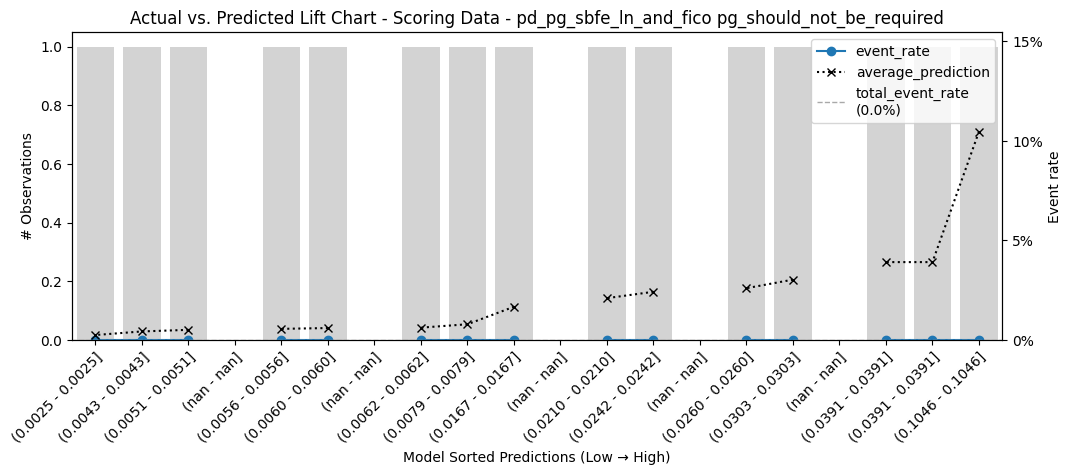

In [30]:
# pd_pg_sbfe_ln_and_fico, test data and subsegment pg_should_be_required
mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_be_required', mt.compute_decile_table(
        data_test_scored[(data_test_scored['booked']) & (data_test_scored['pg_subsegment'] == 'pg_should_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

# pd_pg_sbfe_ln_and_fico, test data and subsegment pg_should_not_be_required
mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required', mt.compute_decile_table(
        data_test_scored[(data_test_scored['booked']) & (data_test_scored['pg_subsegment'] == 'pg_should_not_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_be_required
mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_be_required', mt.compute_decile_table(
        data_scoring_scored[(data_scoring_scored['booked']) & (data_scoring_scored['pg_subsegment'] == 'pg_should_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')


# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_not_be_required
mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required', mt.compute_decile_table(
        data_scoring_scored[(data_scoring_scored['booked']) & (data_scoring_scored['pg_subsegment'] == 'pg_should_not_be_required')], 
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit'
), 'PROB_RANGE')

##### Risk Grade Lift Chart

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

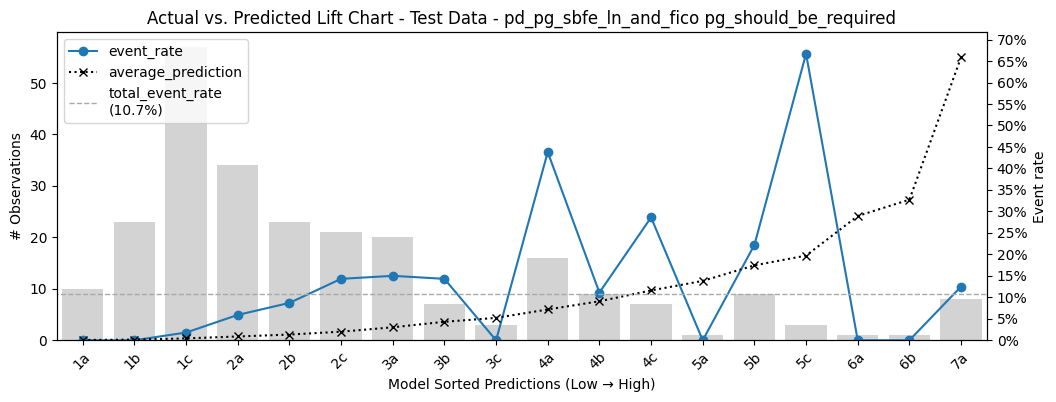

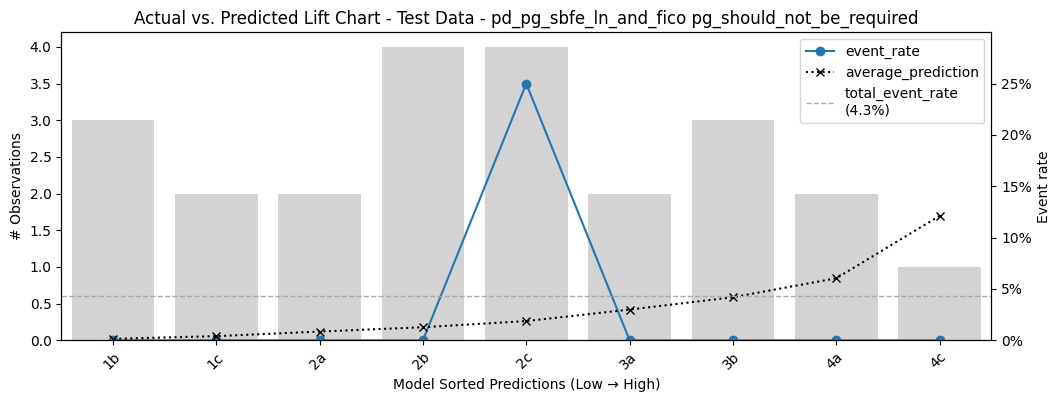

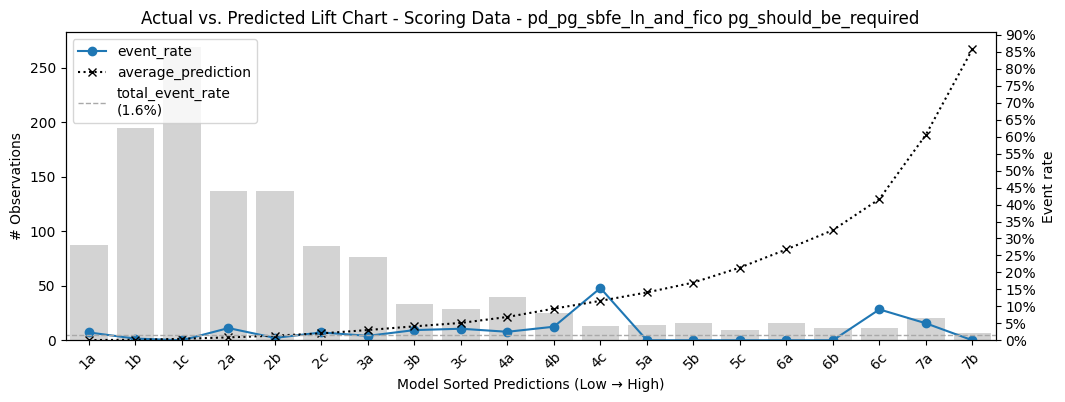

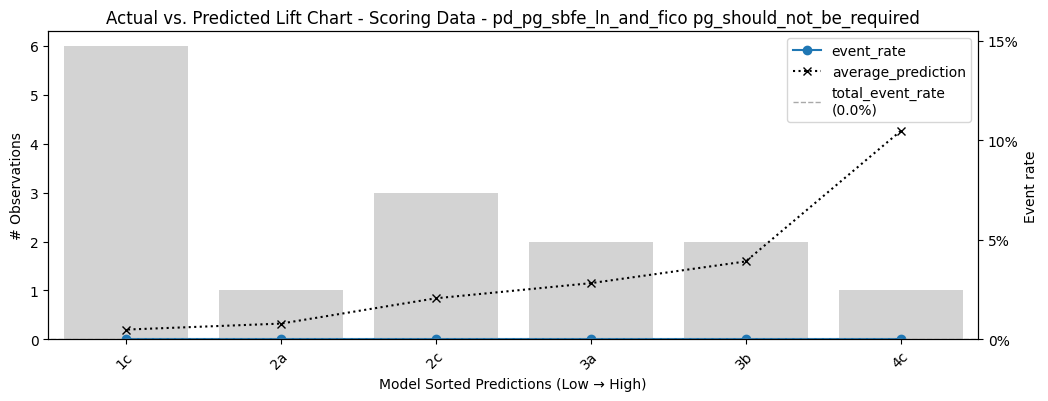

In [31]:
# pd_pg_sbfe_ln_and_fico, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')



# pd_pg_sbfe_ln_and_fico, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_not_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_and_fico, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_hit') & (data['pg_subsegment'] == 'pg_should_not_be_required')]['pd_pg_sbfe_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_and_fico',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


#### pd_pg_sbfe_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

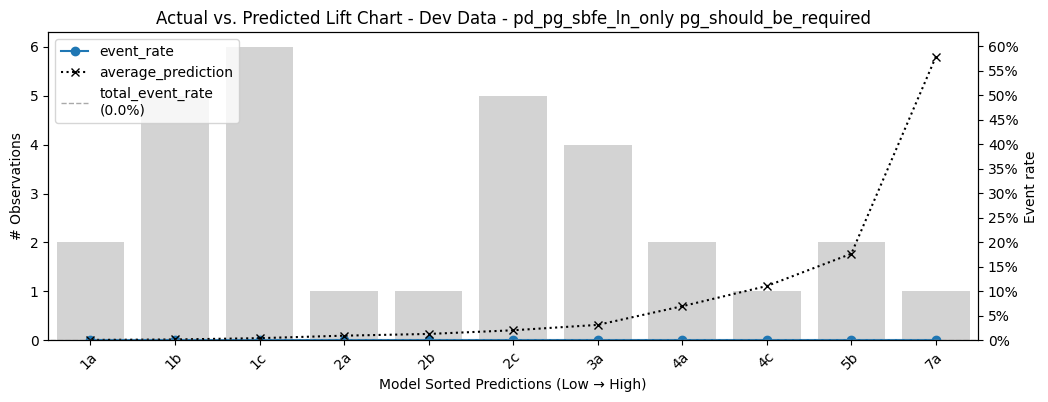

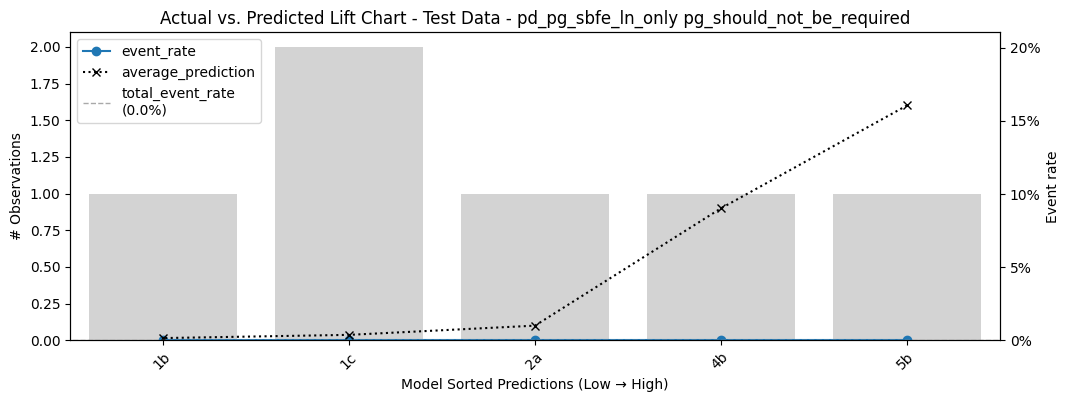

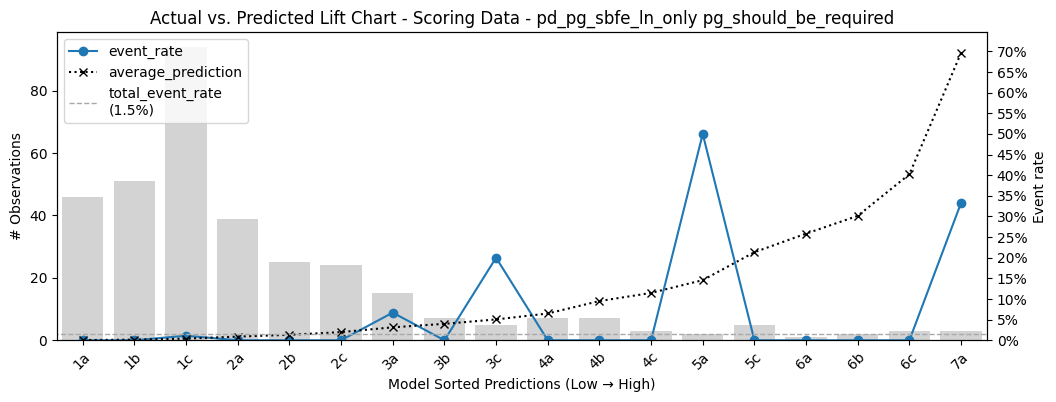

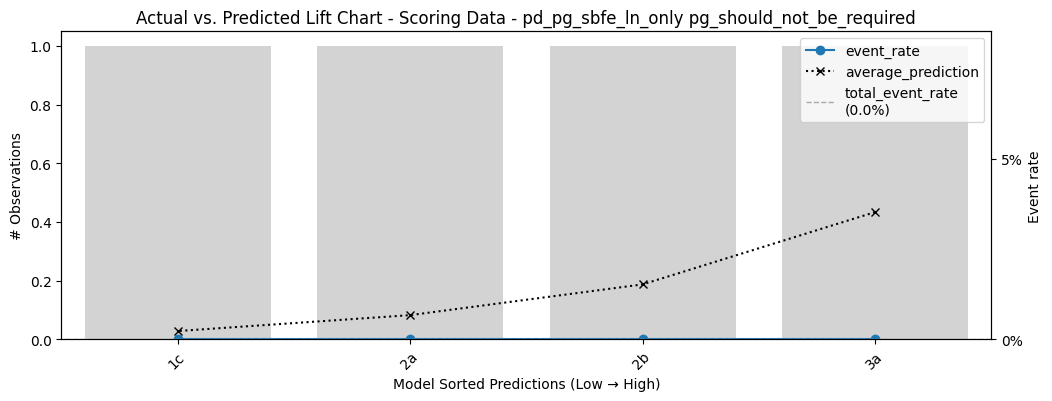

In [32]:
# pd_pg_sbfe_ln_only, dev data and subsegment pg_should_be_required
data = data_dev_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Dev Data - pd_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')


# pd_pg_sbfe_ln_only, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')



# pd_pg_sbfe_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sbfe_ln_only, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit')]['pd_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sbfe_ln_only',
        'is_bad',
        20,
        'pg_and_1_plus_sbfe_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')



#### pd_pg_sba_ln_and_fico

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

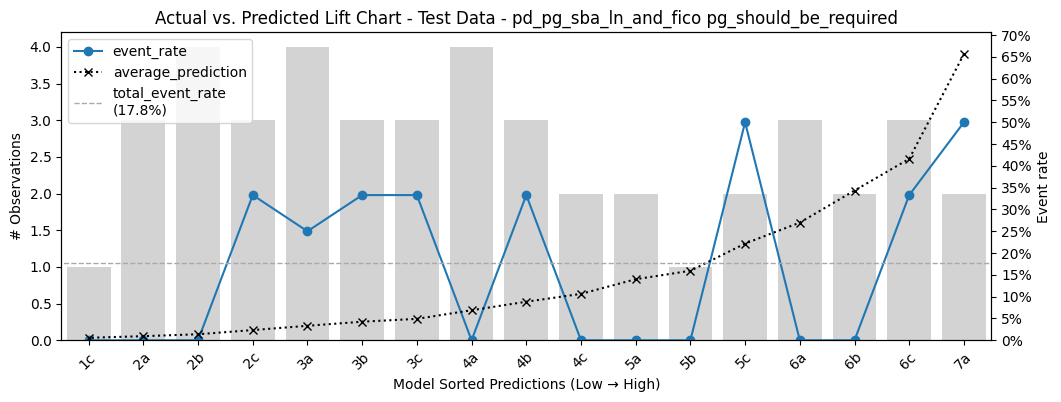

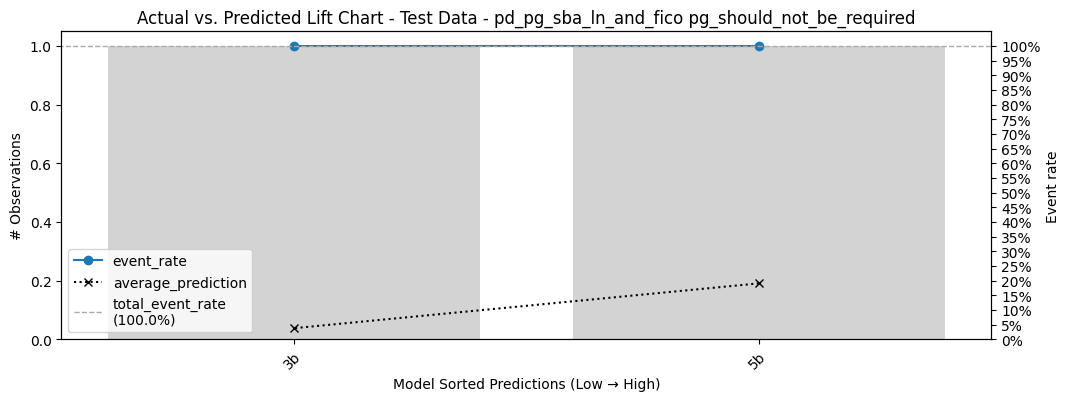

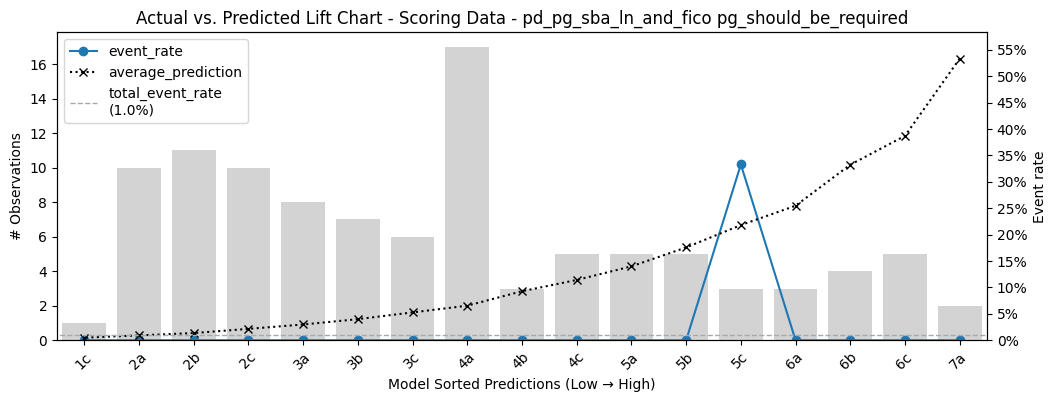

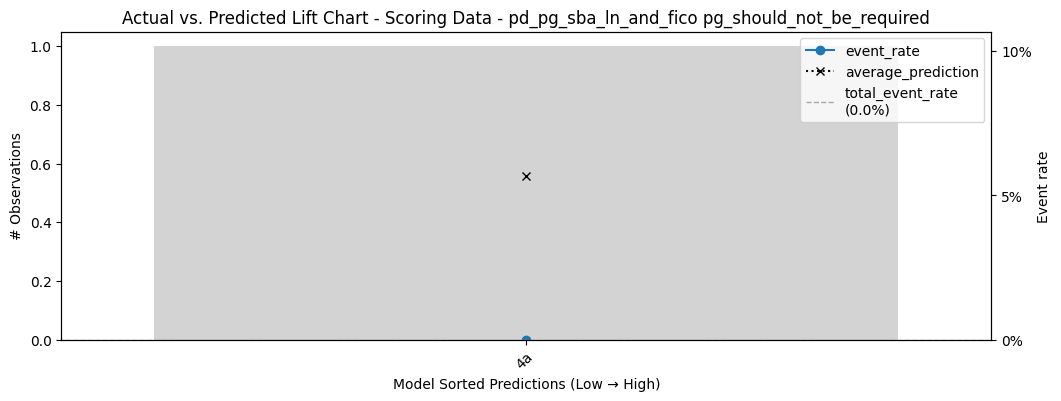

In [33]:
# pd_pg_sba_ln_and_fico, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


# pd_pg_sba_ln_and_fico, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_and_fico, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_and_fico, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit')]['pd_pg_sba_ln_and_fico'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_and_fico pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_sba_ln_and_fico',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


#### pd_pg_sba_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


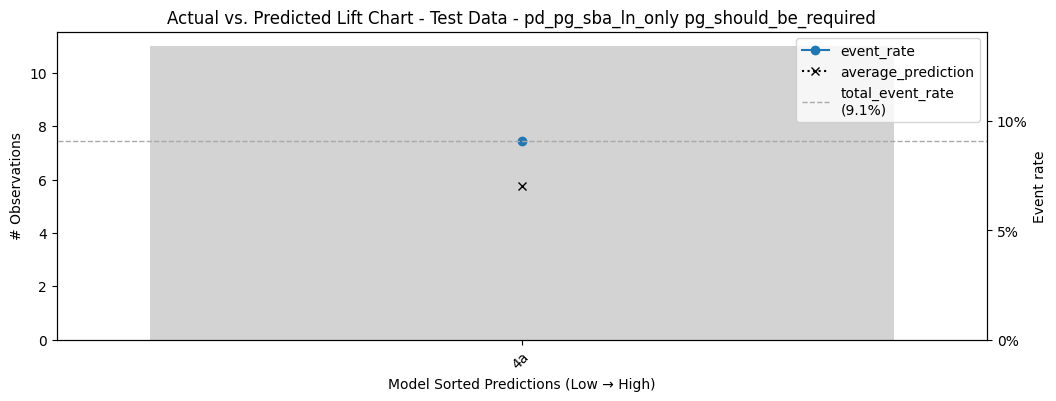

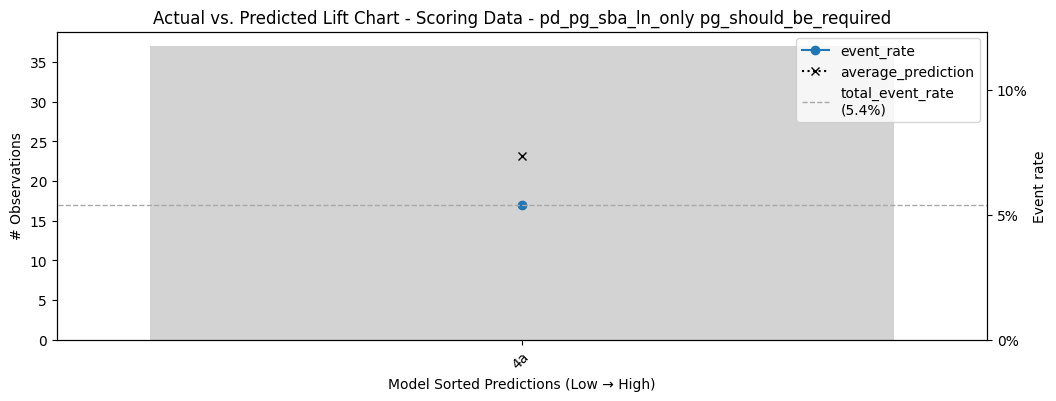

In [34]:
# pd_pg_sba_ln_only, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')


# # pd_pg_sba_ln_only, dev data and subsegment pg_should_not_be_required
# data = data_test_scored.copy()
# data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

# mt.lift_chart_plot('Test Data - pd_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
#         data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
#         'pd_pg_sba_ln_only',
#         'is_bad',
#         20,
#         'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
#         'risk_grades'
# ), 'risk_grades')

# pd_pg_sba_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_sba_ln_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_sba_ln_only, scoring data and subsegment pg_should_not_be_required
# data = data_scoring_scored.copy()
# data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit')]['pd_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

# mt.lift_chart_plot('Scoring Data - pd_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
#         data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
#         'pd_pg_sba_ln_only',
#         'is_bad',
#         20,
#         'pg_and_no_sbfe_tradeline_and_1_plus_sba_tradeline_and_fico_no_hit',
#         'risk_grades'
# ), 'risk_grades')


#### pd_pg_fico_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

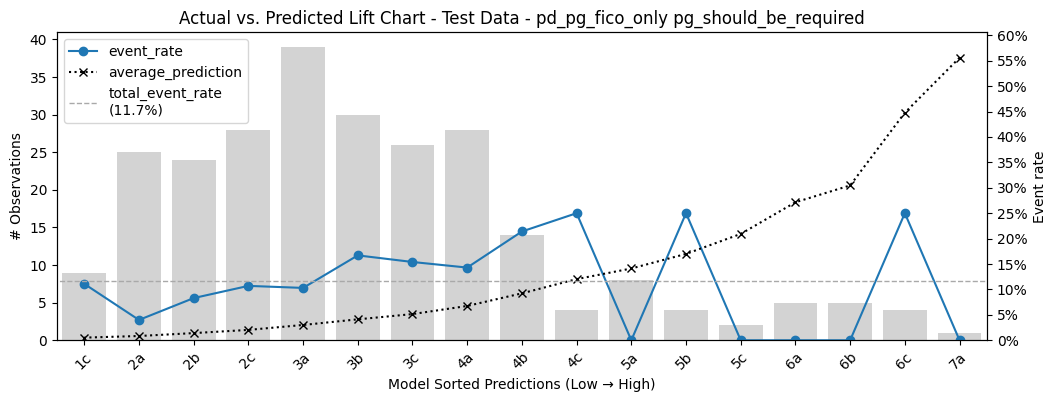

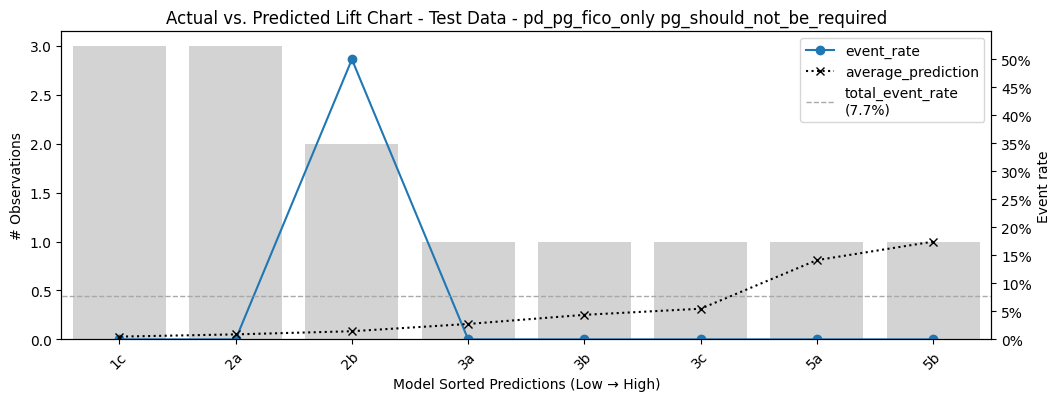

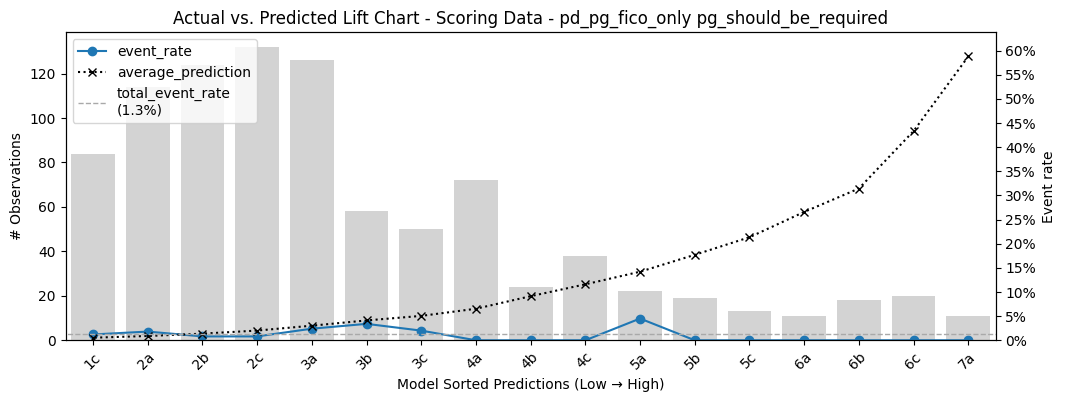

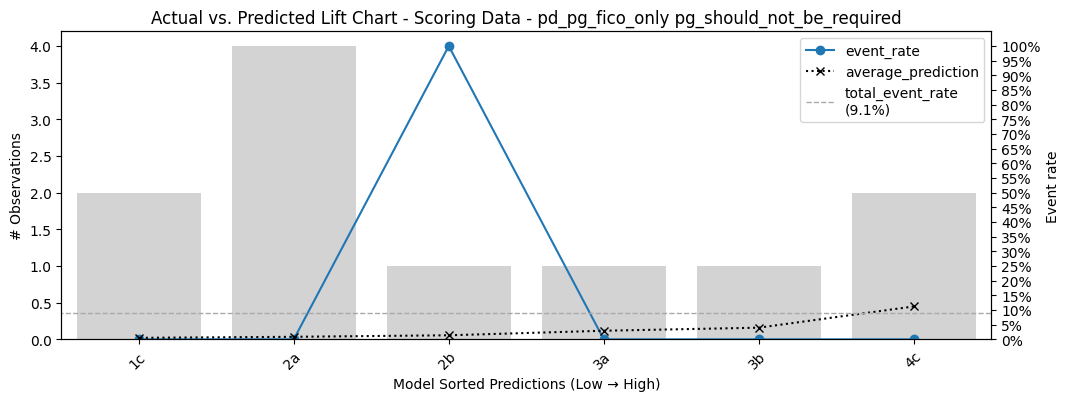

In [35]:
# pd_pg_fico_only, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_fico_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')


# pd_pg_fico_only, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_pg_fico_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_fico_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_fico_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')

# pd_pg_fico_only, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit')]['pd_pg_fico_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_pg_fico_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_pg_fico_only',
        'is_bad',
        20,
        'pg_and_no_sbfe_tradeline_and_no_sba_tradeline_and_fico_hit',
        'risk_grades'
), 'risk_grades')



#### pd_no_pg_sbfe_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

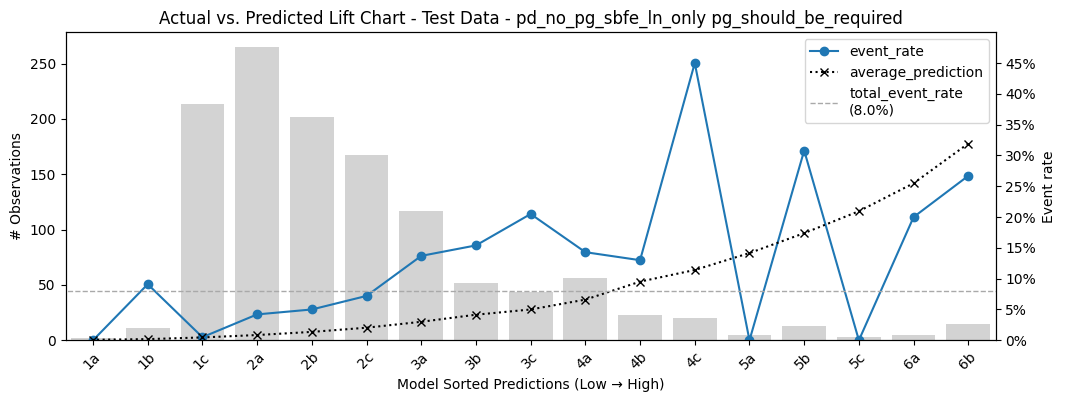

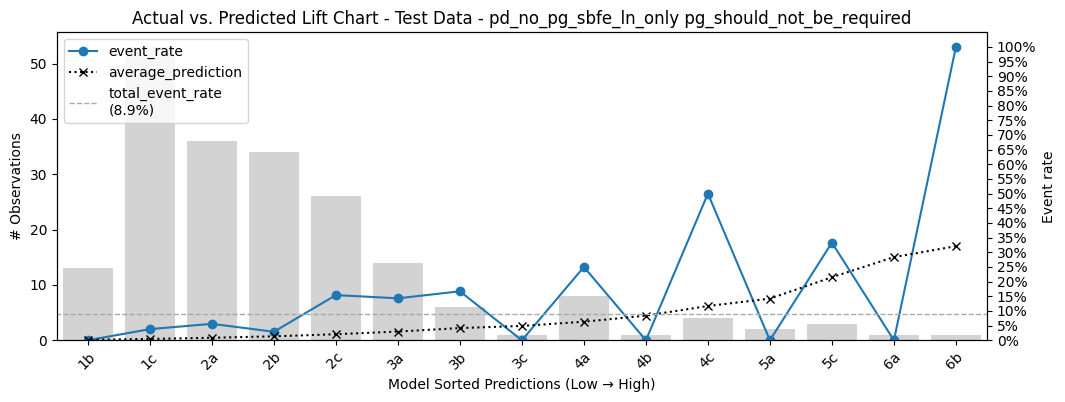

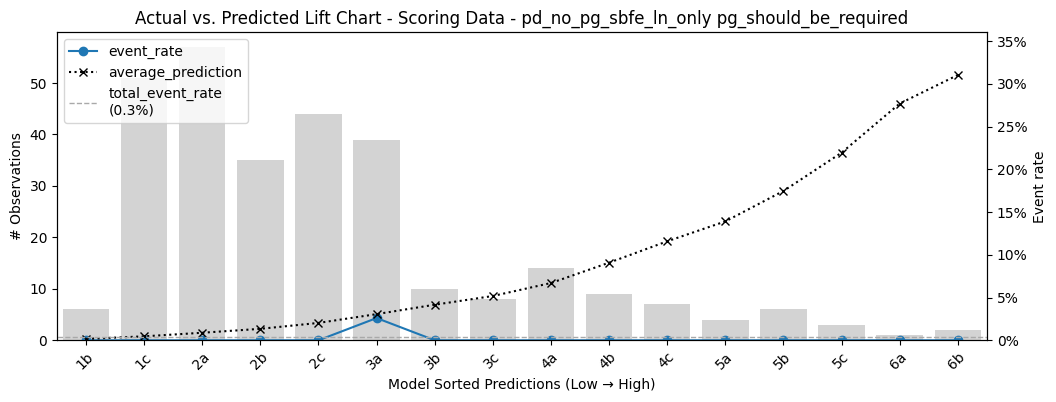

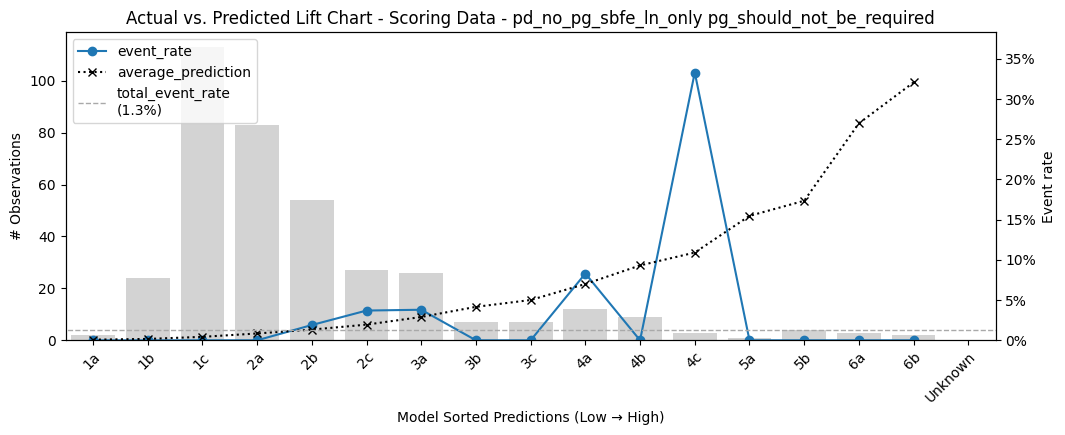

In [36]:
# pd_no_pg_sbfe_ln_only, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')


# pd_no_pg_sbfe_ln_only, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')

# pd_no_pg_sbfe_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sbfe_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')

# pd_no_pg_sbfe_ln_only, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_1_plus_sbfe_tradeline')]['pd_no_pg_sbfe_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sbfe_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_no_pg_sbfe_ln_only',
        'is_bad',
        20,
        'no_pg_and_1_plus_sbfe_tradeline',
        'risk_grades'
), 'risk_grades')


#### pd_no_pg_sba_ln_only

g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebooks\..\resources\model_training.py:913: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
g:\My Drive\projects\otr_adjudication\otr_ln_master_table\otr_ln_master_table\otr_ln_master_table\notebook

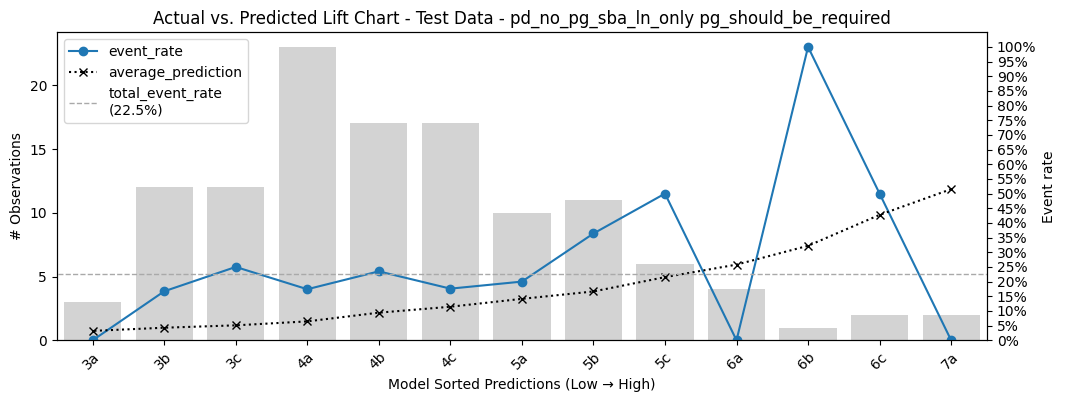

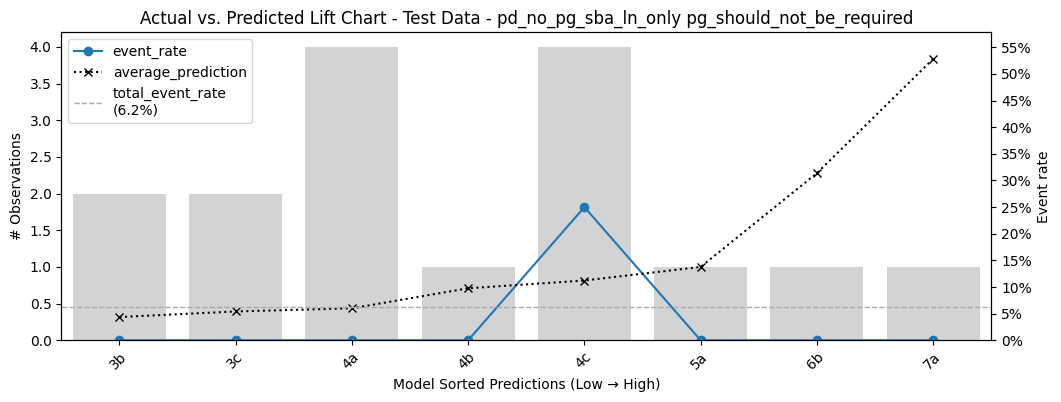

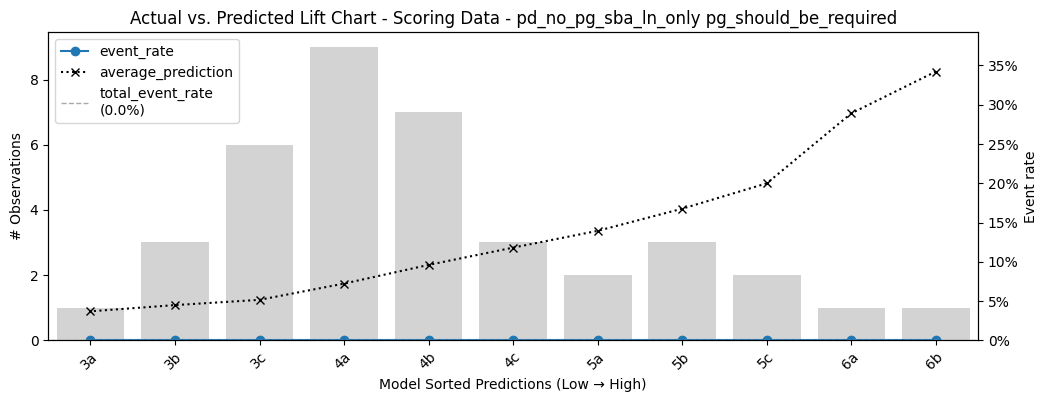

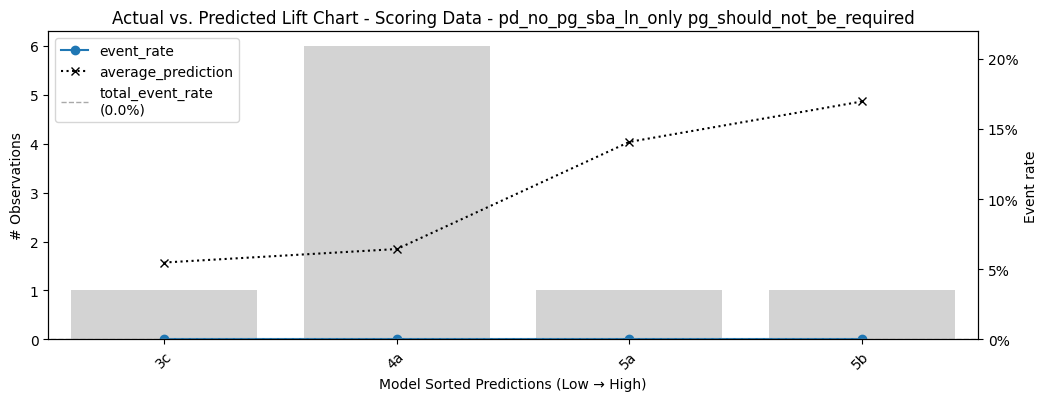

In [37]:
# pd_no_pg_sba_ln_only, dev data and subsegment pg_should_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')


# pd_no_pg_sba_ln_only, dev data and subsegment pg_should_not_be_required
data = data_test_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Test Data - pd_no_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')


# pd_no_pg_sba_ln_only, scoring data and subsegment pg_should_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sba_ln_only pg_should_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_be_required')],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')

# pd_no_pg_sba_ln_only, scoring data and subsegment pg_should_not_be_required
data = data_scoring_scored.copy()
data['risk_grades'] = data[(data['booked']) & (data['risk_grade_path'] == 'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline')]['pd_no_pg_sba_ln_only'].apply(lambda x: mt.assign_risk_grade(x, new_pd_risk_grade_thresholds))

mt.lift_chart_plot('Scoring Data - pd_no_pg_sba_ln_only pg_should_not_be_required',mt.compute_risk_grade_table(
        data[data['booked'] & (data['pg_subsegment'] == 'pg_should_not_be_required')],
        'pd_no_pg_sba_ln_only',
        'is_bad',
        20,
        'no_pg_and_no_1_plus_sbfe_tradeline_and_1_plus_sba_tradeline',
        'risk_grades'
), 'risk_grades')